# Run Modes

Running MAGICC in different modes can be non-trivial. In this notebook we show how to set MAGICC's config flags so that it will run as desired for a few different cases.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
import datetime
import dateutil
from copy import deepcopy


import numpy as np
import pandas as pd


from pymagicc import MAGICC6, rcp26, zero_emissions
from pymagicc.io import MAGICCData

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

## Concentration to emissions hybrid

This is MAGICC's default run mode. In this run mode, MAGICC will run with prescribed concentrations (or a quantity which scales linearly with radiative forcing for aerosol species) until a given point in time and will then switch to running in emissions driven mode.

In [3]:
with MAGICC6() as magicc:
    res = magicc.run(rcp26)

In [4]:
# NBVAL_IGNORE_OUTPUT
res.head()

time                                                                                           1765-01-01  \
model scenario region variable                                  unit       climate_model todo               
IMAGE RCP26    World  Atmospheric Concentrations|CH4            ppb        MAGICC6       N/A    721.89411   
                      Atmospheric Concentrations|CO2            ppm        MAGICC6       N/A    278.05158   
                      Atmospheric Concentrations|CO2 Equivalent CO2eqppm   MAGICC6       N/A    277.01467   
                      Atmospheric Concentrations|N2O            ppb        MAGICC6       N/A    272.95961   
                      Emissions|BC|MAGICC AFOLU                 Mt BC / yr MAGICC6       N/A      0.00000   

time                                                                                           1766-01-01  \
model scenario region variable                                  unit       climate_model todo               
IMAGE RCP26    World  Atmospheric Concentrations|CH4            ppb        MAGICC6       N/A   722.617280   
                      Atmospheric Concentrations|CO2            ppm        MAGICC6       N/A   278.160730   
                      Atmospheric Concentrations|CO2 Equivalent CO2eqppm   MAGICC6       N/A   278.662940   
                      Atmospheric Concentrations|N2O            ppb        MAGICC6       N/A   272.982810   
                      Emissions|BC|MAGICC AFOLU                 Mt BC / yr MAGICC6       N/A     0.023812   

time                                                                                           1767-01-01  \
model scenario region variable                                  unit       climate_model todo               
IMAGE RCP26    World  Atmospheric Concentrations|CH4            ppb        MAGICC6       N/A   723.324360   
                      Atmospheric Concentrations|CO2            ppm        MAGICC6       N/A   278.280060   
                      Atmospheric Concentrations|CO2 Equivalent CO2eqppm   MAGICC6       N/A   278.724070   
                      Atmospheric Concentrations|N2O            ppb        MAGICC6       N/A   273.005580   
                      Emissions|BC|MAGICC AFOLU                 Mt BC / yr MAGICC6       N/A     0.047624   

time                                                                                           1768-01-01  \
model scenario region variable                                  unit       climate_model todo               
IMAGE RCP26    World  Atmospheric Concentrations|CH4            ppb        MAGICC6       N/A   724.011480   
                      Atmospheric Concentrations|CO2            ppm        MAGICC6       N/A   278.406040   
                      Atmospheric Concentrations|CO2 Equivalent CO2eqppm   MAGICC6       N/A   278.770960   
                      Atmospheric Concentrations|N2O            ppb        MAGICC6       N/A   273.027990   
                      Emissions|BC|MAGICC AFOLU                 Mt BC / yr MAGICC6       N/A     0.071435   

time                                                                                           1769-01-01  \
model scenario region variable                                  unit       climate_model todo               
IMAGE RCP26    World  Atmospheric Concentrations|CH4            ppb        MAGICC6       N/A   724.674780   
                      Atmospheric Concentrations|CO2            ppm        MAGICC6       N/A   278.535130   
                      Atmospheric Concentrations|CO2 Equivalent CO2eqppm   MAGICC6       N/A   278.821920   
                      Atmospheric Concentrations|N2O            ppb        MAGICC6       N/A   273.050070   
                      Emissions|BC|MAGICC AFOLU                 Mt BC / yr MAGICC6       N/A     0.095247   

time                                                                                           1770-01-01  \
model scenario region variable                                  unit   

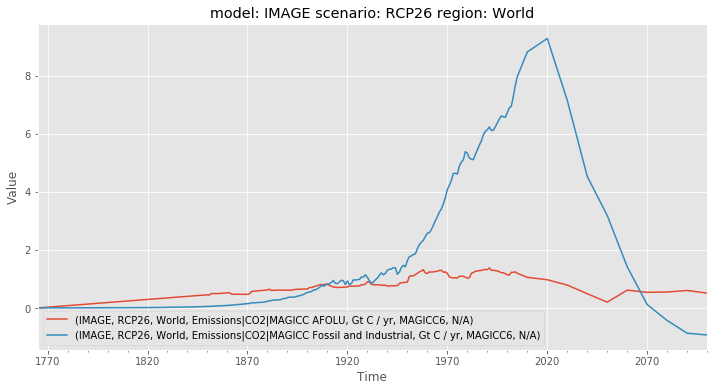

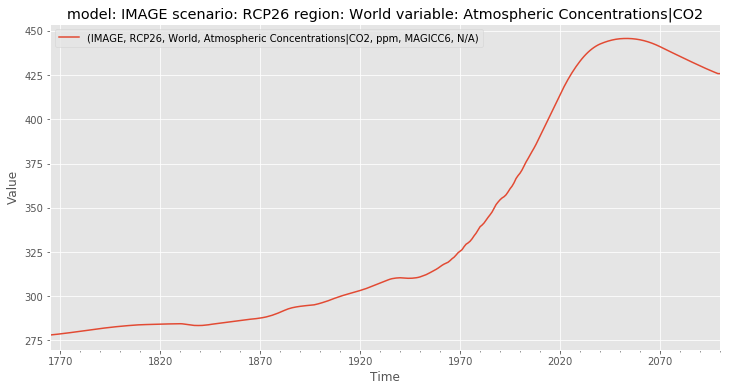

In [5]:
res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time");
res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time");

The switches which control the time at which MAGICC switches from concentrations driven to emissions driven are all in the form `GAS_SWITCHFROMXXX2EMIS_YEAR` e.g. `CO2_SWITCHFROMCONC2EMIS_YEAR` and `BCOC_SWITCHFROMRF2EMIS_YEAR`. 

Changing the value of these switches will alter how MAGICC runs.

In [6]:
df = deepcopy(rcp26)
df.set_meta("RCP26_altered_co2_switch", name="scenario")
with MAGICC6() as magicc:
    res.append(magicc.run(
        df, 
        co2_switchfromconc2emis_year=1850
    ))

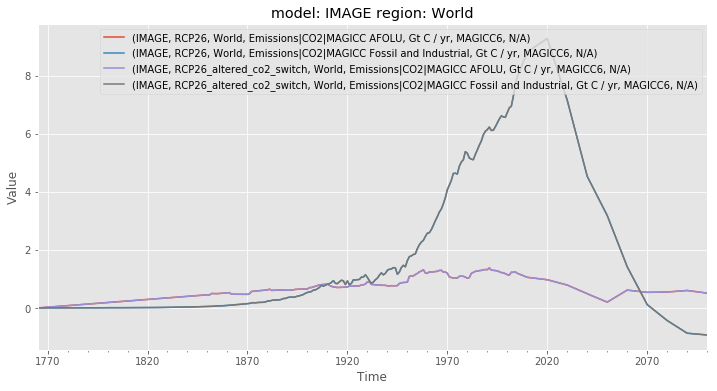

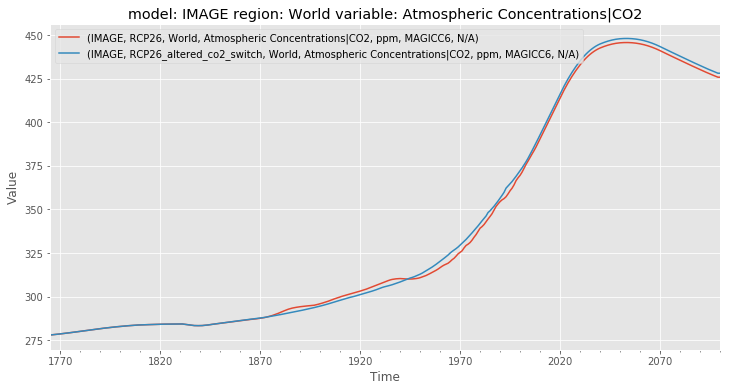

In [7]:
res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time");
res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time");

As we can see, the emissions remain unchanged but the concentrations are altered as MAGICC is now running emissions driven from 1850 rather than 2005 (the default).

To get a fully emissions driven run, you need to change all of the relevant `GAS_SWITCHXXX2EMIS_YEAR` flags.

## CO$_2$ Emissions Driven Only

We can get a CO$_2$ emissions only driven run like shown.

INFO:root:>=13 labels, not applying legend


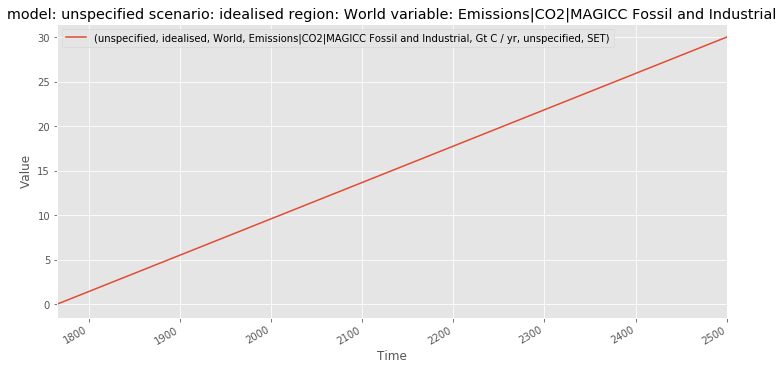

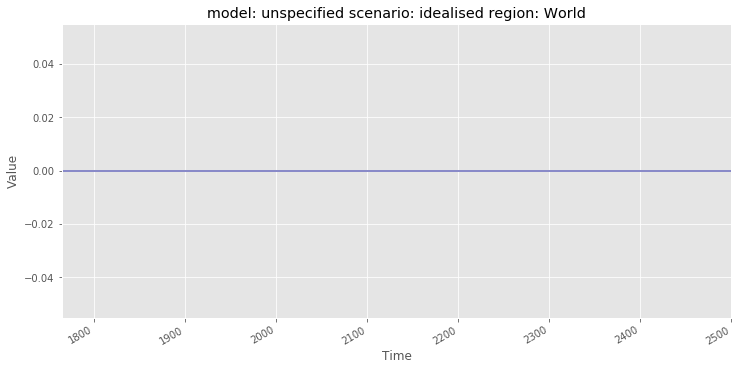

In [8]:
df = zero_emissions.timeseries()

time = zero_emissions["time"]
df.loc[
    (
        df.index.get_level_values("variable")
        == "Emissions|CO2|MAGICC Fossil and Industrial"
    ),
    :,
] = np.linspace(0, 30, len(time))

scen = MAGICCData(df)
scen.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
scen.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time");

In [9]:
with MAGICC6() as magicc:
    co2_only_res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        rf_total_constantafteryr=5000,
        rf_total_runmodus="CO2",
        co2_switchfromconc2emis_year=min(scen["time"]).year,
    )

Ignoring input data which is not required for .SCEN file


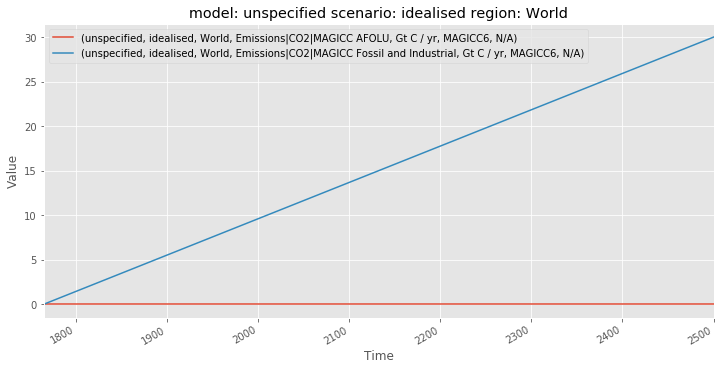

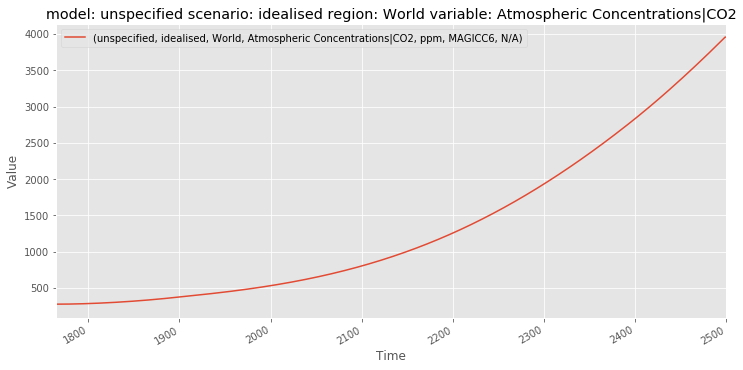

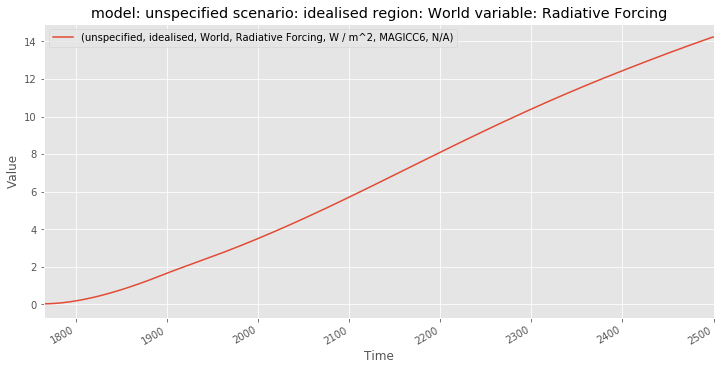

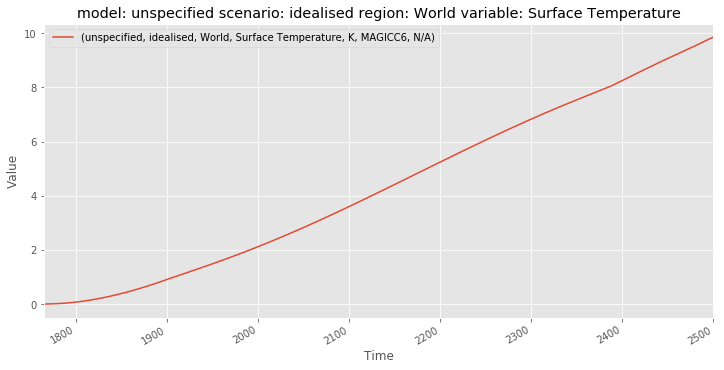

In [10]:
co2_only_res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time")
co2_only_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time")
co2_only_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
co2_only_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

## Prescribed Forcing Driven Only

It is also possible to examine MAGICC's response to a prescribed radiative forcing only.

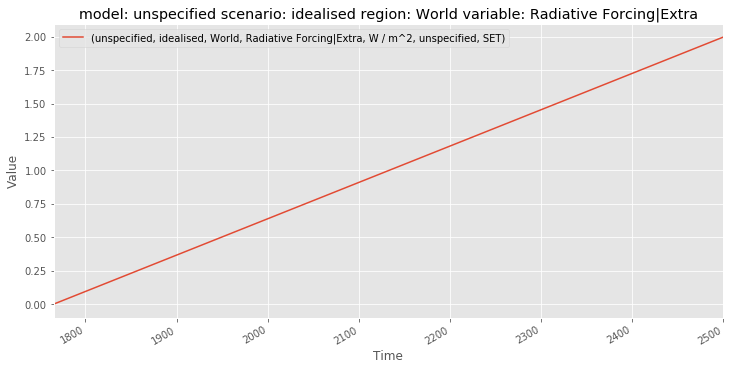

In [11]:
time = zero_emissions["time"]

forcing_external = 2.0 * np.arange(0, len(time)) / len(time)
forcing_ext = MAGICCData(
    forcing_external,
    columns={
        "index": time,
        "scenario": ["idealised"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        "variable": ["Radiative Forcing|Extra"],
        "unit": ["W / m^2"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
forcing_ext.metadata = {"header": "External radiative forcing with linear increase"}
forcing_ext.line_plot(x="time");

In [12]:
with MAGICC6() as magicc:
    forcing_ext_filename = "CUSTOM_EXTRA_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), 
        magicc.version
    )
    ext_forc_only_res = magicc.run(
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="QEXTRA",
        endyear=max(time).year,  
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure
        rf_total_constantafteryr=5000,
    )

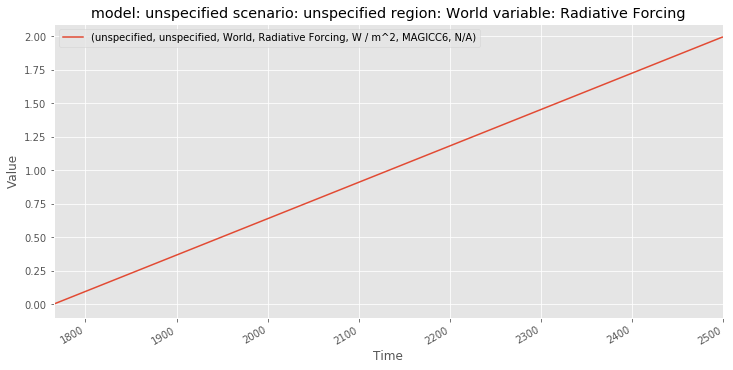

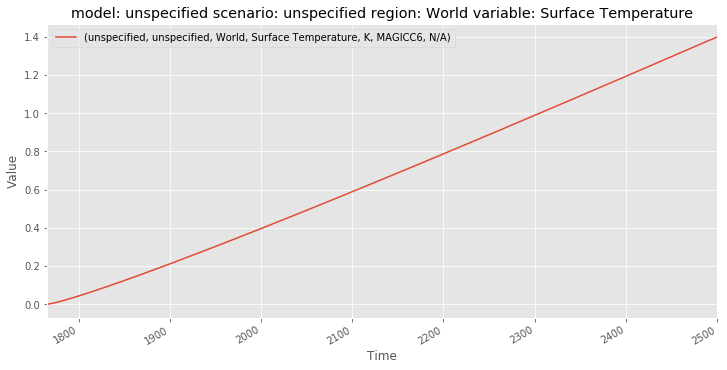

In [13]:
ext_forc_only_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
ext_forc_only_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

## Zero Temperature Output

Getting MAGICC to return zero for its temperature output is surprisingly difficult. To help address this, we add the `set_zero_config` method to our MAGICC classes.

In [14]:
print(MAGICC6.set_zero_config.__doc__)

Set config such that radiative forcing and temperature output will be zero

        This method is intended as a convenience only, it does not handle everything in
        an obvious way. Adjusting the parameter settings still requires great care and
        may behave unepexctedly.
        


In [15]:
with MAGICC6() as magicc:
    magicc.set_zero_config()
    res_zero = magicc.run()

Ignoring input data which is not required for .SCEN file


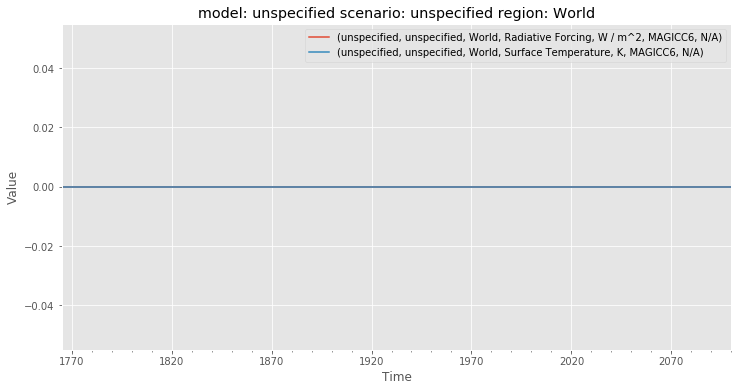

In [16]:
res_zero.filter(
    variable=[
        "Surface Temperature",
        "Radiative Forcing"
    ],
    region="World"
).line_plot(x="time");

## CO$_2$ Emissions and Prescribed Forcing

It is also possible to run MAGICC in a mode which is CO$_2$ emissions driven but also includes a prescribed external forcing.

INFO:root:>=13 labels, not applying legend


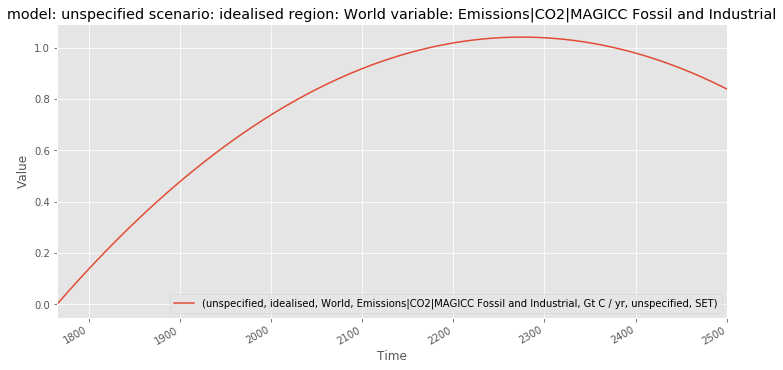

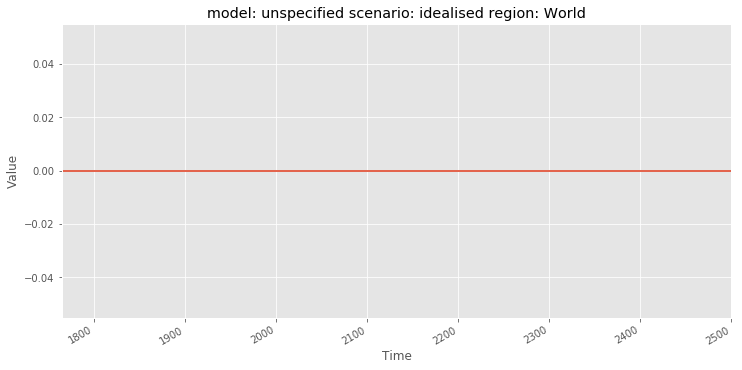

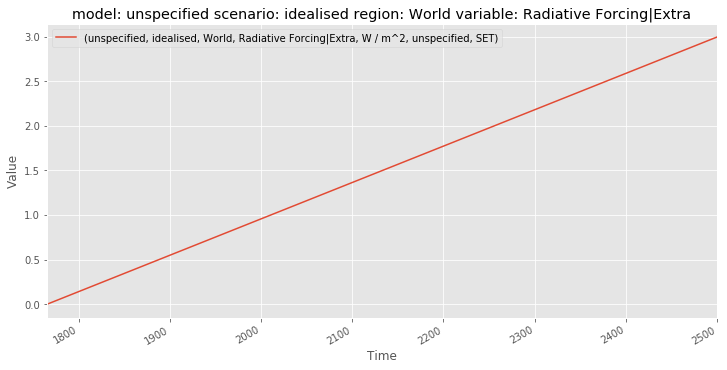

In [17]:
df = zero_emissions.timeseries()

time = zero_emissions["time"]
emms_fossil_co2 = (
    np.linspace(0, 3, len(time))
    - (1 + (np.arange(len(time)) - 500) / 500)**2
)
df.loc[
    (
        df.index.get_level_values("variable")
        == "Emissions|CO2|MAGICC Fossil and Industrial"
    ),
    :,
] = emms_fossil_co2

scen = MAGICCData(df)
scen.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
scen.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time");

forcing_external = 3.0 * np.arange(0, len(time)) / len(time)
forcing_ext = MAGICCData(
    forcing_external,
    columns={
        "index": time,
        "scenario": ["idealised"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        "variable": ["Radiative Forcing|Extra"],
        "unit": ["W / m^2"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
forcing_ext.metadata = {"header": "External radiative forcing with linear increase"}
forcing_ext.line_plot(x="time");

In [18]:
with MAGICC6() as magicc:
    magicc.set_zero_config()  # very important, try commenting this out and see what happens
    forcing_ext_filename = "CUSTOM_EXTRA_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), 
        magicc.version
    )
    co2_emms_ext_forc_res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        co2_switchfromconc2emis_year=min(scen["time"]).year,
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="ALL",  # default but just in case
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure 
        rf_total_constantafteryr=5000,
    )

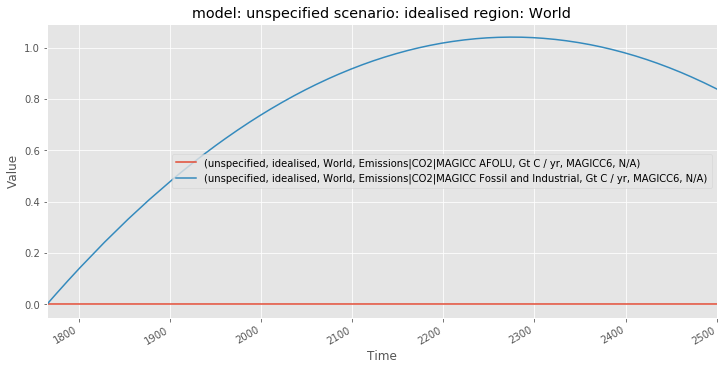

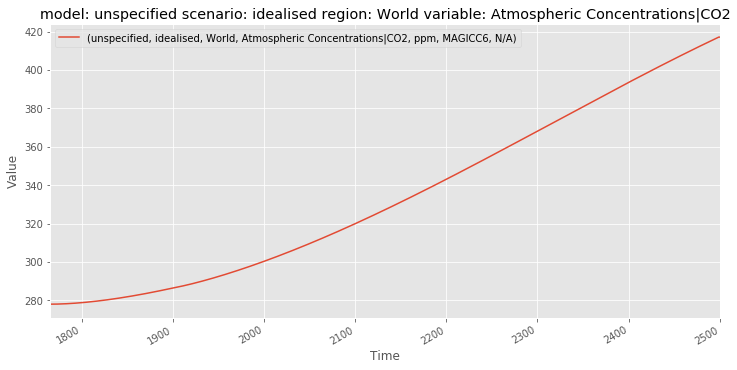

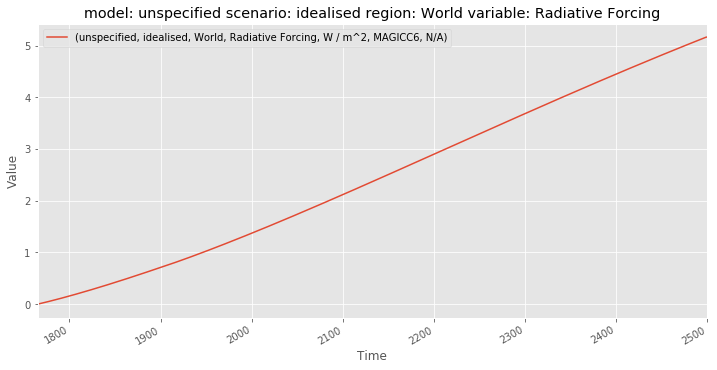

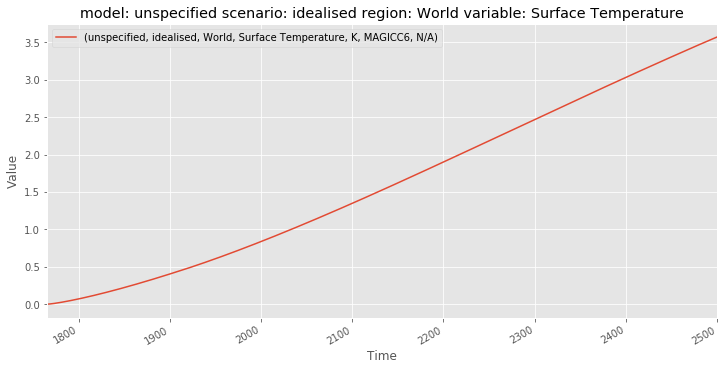

In [19]:
co2_emms_ext_forc_res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

If we adjust MAGICC's CO$_2$ temperature feedback start year, it is easier to see what is going on.

In [20]:
with MAGICC6() as magicc:
    magicc.set_zero_config()  
        
    forcing_ext_filename = "CUSTOM_EXTRA_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), 
        magicc.version
    )
    for temp_feedback_year in [2000, 2100, 3000]:
        scen.set_meta(
            "idealised_{}_CO2_temperature_feedback".format(temp_feedback_year), 
            name="scenario"
        )
        
        co2_emms_ext_forc_res.append(magicc.run(
            scen,
            endyear=scen["time"].max().year,
            co2_switchfromconc2emis_year=min(scen["time"]).year,
            rf_extra_read=1,
            file_extra_rf=forcing_ext_filename,
            rf_total_runmodus="ALL", 
            rf_initialization_method="ZEROSTARTSHIFT",
            rf_total_constantafteryr=5000,
            co2_tempfeedback_yrstart=temp_feedback_year, 
        ))

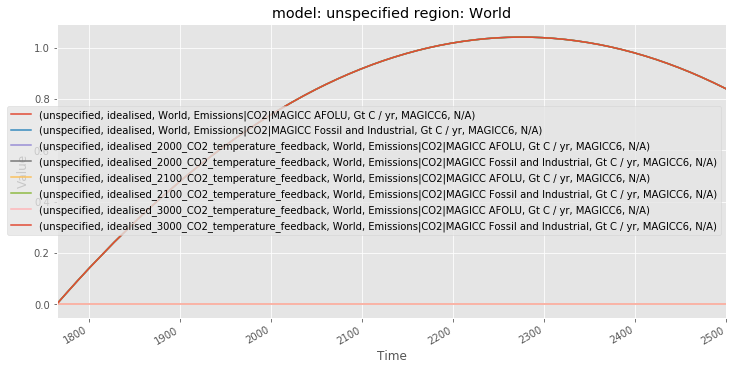

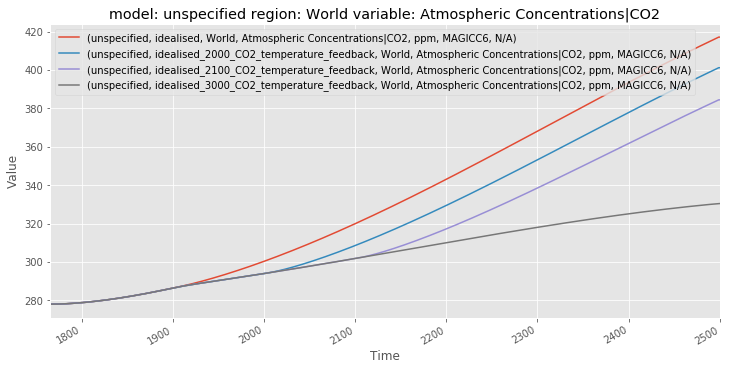

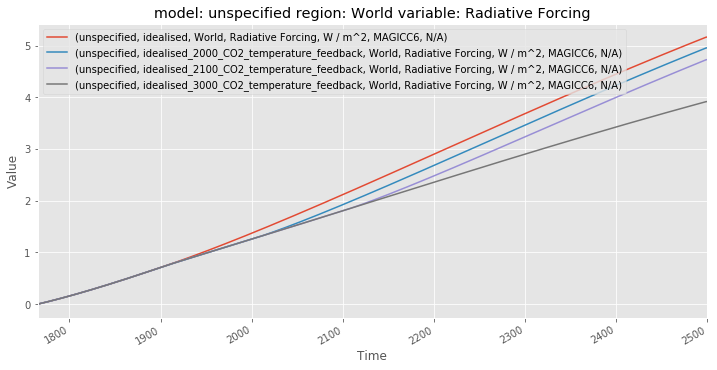

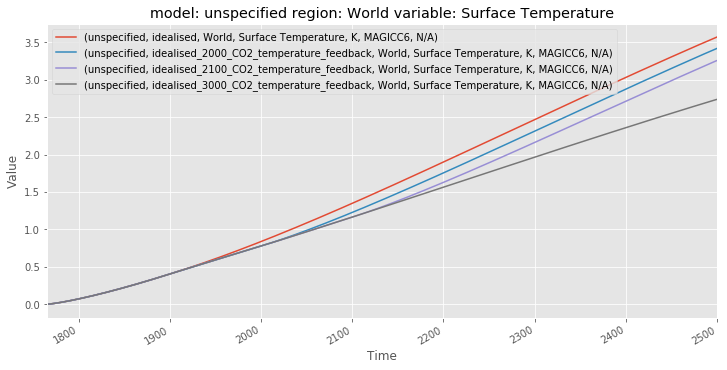

In [21]:
co2_emms_ext_forc_res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

## CO$_2$ Concentrations Driven

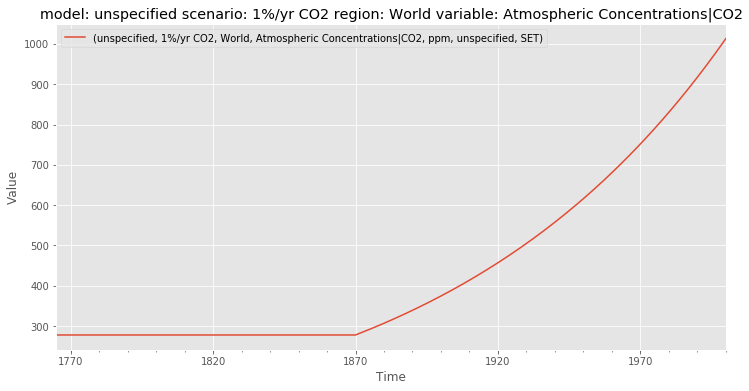

In [22]:
time = zero_emissions["time"]

co2_concs = 278 * np.ones_like(time)
co2_concs[105:] = 278 * 1.01 ** (np.arange(0, len(time[105:])))

co2_concs = MAGICCData(
    co2_concs,
    columns={
        "index": time,
        "scenario": ["1%/yr CO2"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        "variable": ["Atmospheric Concentrations|CO2"],
        "unit": ["ppm"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
co2_concs = co2_concs.filter(year=range(1700, 2001))
time = co2_concs["time"]
co2_concs.metadata = {"header": "1%/yr atmospheric CO2 concentration increase"}
co2_concs.line_plot(x="time");

In [23]:
with MAGICC6() as magicc:
    co2_conc_filename = "1PCT_CO2_CONC.IN"
    co2_concs.write(
        join(magicc.run_dir, co2_conc_filename), 
        magicc.version
    )
    co2_conc_driven_res = magicc.run(
        file_co2_conc=co2_conc_filename,
        co2_switchfromconc2emis_year=max(time).year,
        co2_tempfeedback_switch=1,
        co2_tempfeedback_yrstart=1870,
        co2_fertilization_yrstart=1870,
        rf_total_runmodus="CO2",
        rf_total_constantafteryr=max(time).year,
        endyear=max(time).year,
        out_inverseemis=1,
    )

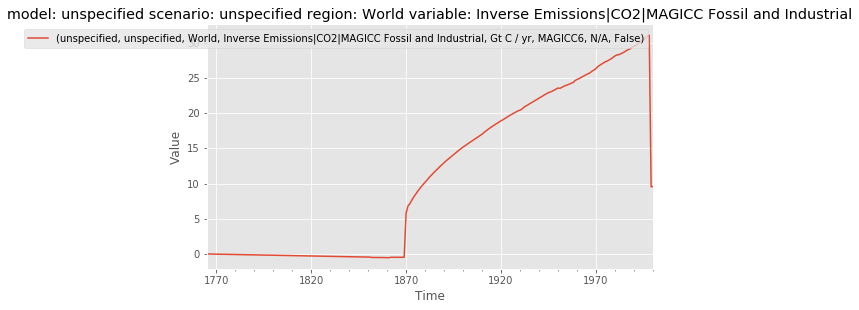

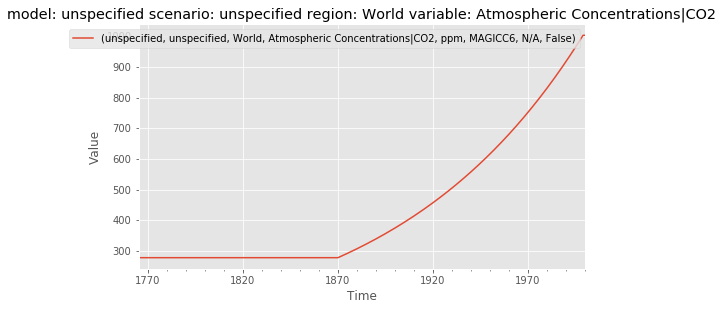

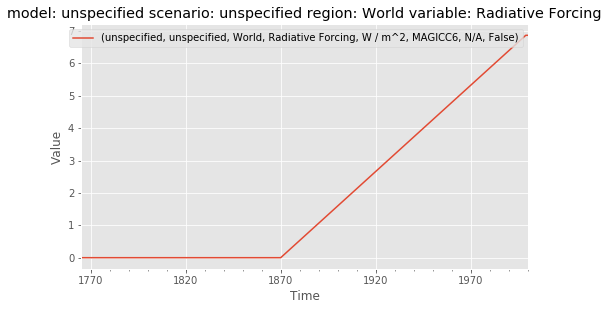

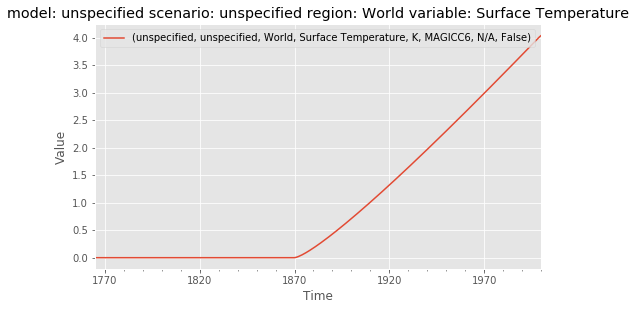

In [24]:
co2_conc_driven_res.filter(
    variable="Inverse Emis*CO2*",
    region="World"
).line_plot(x="time", figsize=(8, 4.5))
co2_conc_driven_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time", figsize=(8, 4.5))
co2_conc_driven_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time", figsize=(8, 4.5))
co2_conc_driven_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time", figsize=(8, 4.5));